<a href="https://colab.research.google.com/github/MarioAuditore/TDA-for-Travelling-Salesman/blob/main/train_tsp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Based on "The Transformer Network for the Traveling Salesman Problem"

Xavier Bresson, Thomas Laurent, Feb 2021<br>

Arxiv : https://arxiv.org/pdf/2103.03012.pdf<br>
Talk : https://ipam.wistia.com/medias/0jrweluovs<br>
Slides : https://t.co/ySxGiKtQL5<br>

This code trains the transformer network by reinforcement learning.<br>
Use the beam search code to test the trained network.


In [19]:
!git clone https://github.com/MarioAuditore/TDA-for-Travelling-Salesman.git

Cloning into 'TDA-for-Travelling-Salesman'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 101 (delta 13), reused 0 (delta 0), pack-reused 72
Receiving objects: 100% (101/101), 104.56 MiB | 34.95 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [20]:
import os

os.chdir('/content/TDA-for-Travelling-Salesman')

In [21]:
!pip install 'pyconcorde @ git+https://github.com/jvkersch/pyconcorde'

  Cloning https://github.com/jvkersch/pyconcorde to /tmp/pip-install-do3l_ua7/pyconcorde_7380eeb0aaa44df3ab19335c568af971
  Running command git clone --filter=blob:none --quiet https://github.com/jvkersch/pyconcorde /tmp/pip-install-do3l_ua7/pyconcorde_7380eeb0aaa44df3ab19335c568af971
  Resolved https://github.com/jvkersch/pyconcorde to commit 8a6b193b79ebdf8f07e0b0635722b3b4edbc1560
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [22]:
!pip install giotto-ph

In [23]:
# ================
# Libs
# ================

import torch
import torch.nn as nn
from tqdm import tqdm
import gph

# Models
from tsp_transformer.model import TSP_net, compute_tour_length


import time
import argparse
import os
import datetime


# visualization
%matplotlib inline
# from IPython.display import set_matplotlib_formats, clear_output
# set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd


import networkx as nx
from scipy.spatial.distance import pdist, squareform
from concorde.tsp import TSPSolver # !pip install -e pyconcorde


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [24]:
###################
# Hardware : CPU / GPU(s)
###################

if torch.backends.mps.is_available():
    gpu_id = '0'
    device = torch.device("mps")

elif torch.cuda.is_available():
    gpu_id = '0' # select a single GPU
    # gpu_id = '2,3' # select multiple GPUs
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))

else:
    device = torch.device("cpu")
    gpu_id = -1 # select CPU


print(device)

GPU name: Tesla T4, gpu_id: 0
cuda


In [25]:
# ================
# Hyper-parameters
# ================

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

args = DotDict()
args.gpu_id = gpu_id

# TSP problem number of nodes
args.nb_nodes = 10 # TSP10
# args.nb_nodes = 20 # TSP20

# Transformer parameters
args.dim_emb = 128 # dimension of embeddings in transformer
args.dim_ff = 512 # dimension of feed forward layers
args.dim_nodes = 2
args.dim_model_input = 6 # dimension of input features
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8

#
args.nb_epochs = 20 # number of epochs
args.batch_size = 128 # batch size
args.nb_batch_per_epoch = 250 # number of batches to generate on each epoch for training
args.nb_batch_eval = 100 # number of batches to generate on each epoch for evaluation
args.lr = 1e-4 # optimiser lr
args.tol = 1e-3 # model should perform better w.r.t tolerance to be updated
args.batchnorm = True  # if batchnorm=True  than batch norm is used
# args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)


{'gpu_id': '0', 'nb_nodes': 10, 'dim_emb': 128, 'dim_ff': 512, 'dim_nodes': 2, 'dim_model_input': 6, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 20, 'batch_size': 128, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


# Training
## Setup

In [26]:
###################
# Instantiate a training network and a baseline network
###################
torch.manual_seed(42)
np.random.seed(42)

try:
    del model_train # remove existing model
    del model_baseline # remove existing model
except:
    pass

model_train = TSP_net(args.dim_model_input,
                      args.dim_emb,
                      args.dim_ff,
                      args.nb_layers_encoder,
                      args.nb_layers_decoder,
                      args.nb_heads,
                      args.max_len_PE,
                      batchnorm=args.batchnorm)

model_baseline = TSP_net(args.dim_model_input,
                         args.dim_emb,
                         args.dim_ff,
                         args.nb_layers_encoder,
                         args.nb_layers_decoder,
                         args.nb_heads,
                         args.max_len_PE,
                         batchnorm=args.batchnorm)

if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count() + " cuda devices found, doing parallel training.")
    model_train = nn.DataParallel(model_train)
    model_baseline = nn.DataParallel(model_baseline)

optimizer = torch.optim.Adam(model_train.parameters(), lr = args.lr)

model_train = model_train.to(device)
model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')

# Logs
os.system("mkdir logs")
time_stamp=datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S")
file_name = 'logs'+'/'+time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id) + ".txt"
file = open(file_name,"w",1)
file.write(time_stamp+'\n\n')
for arg in vars(args):
    file.write(arg)
    hyper_param_val="={}".format(getattr(args, arg))
    file.write(hyper_param_val)
    file.write('\n')
file.write('\n\n')
plot_performance_train = []
plot_performance_baseline = []
all_strings = []
epoch_ckpt = 0
tot_time_ckpt = 0


# # Uncomment these lines to re-start training with saved checkpoint
# ====================================================================
# checkpoint_file = "checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl"
# checkpoint = torch.load(checkpoint_file, map_location=device)
# epoch_ckpt = checkpoint['epoch'] + 1
# tot_time_ckpt = checkpoint['tot_time']
# plot_performance_train = checkpoint['plot_performance_train']
# plot_performance_baseline = checkpoint['plot_performance_baseline']
# model_baseline.load_state_dict(checkpoint['model_baseline'])
# model_train.load_state_dict(checkpoint['model_train'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
# del checkpoint
# ====================================================================



{'gpu_id': '0', 'nb_nodes': 10, 'dim_emb': 128, 'dim_ff': 512, 'dim_nodes': 2, 'dim_model_input': 6, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 20, 'batch_size': 128, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}



## Test
### Best solution

In [27]:
from joblib import Parallel, delayed

create_checkpoint = False
test_size = 1000
n_nodes = args.nb_nodes

if create_checkpoint:
    x = torch.rand(test_size, n_nodes, args.dim_nodes, device='cpu')

    def best_path(points):
        solution = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False)
        return compute_tour_length(points[None, :], solution.tour[None, :]).to('cpu')

    lengths = Parallel(n_jobs=-1)(delayed(best_path)(points) for points in x)

    best_length_mean = torch.tensor(lengths).mean()

    data_dir = os.path.join("data")
    torch.save({ 'x': x, 'mean': best_length_mean}, '{}.pkl'.format(data_dir + f"/{test_size}tsp{n_nodes}"))

### TSP tasks as validation checkpoints

In [28]:
###################
# Small test set for quick algorithm comparison
# Note : this can be removed
###################

checkpoint = None

if args.nb_nodes==10 : checkpoint = torch.load("data/1000tsp10.pkl")
if args.nb_nodes==20 : checkpoint = torch.load("data/1000tsp20.pkl")

if checkpoint is not None:
    x_test_tsp = checkpoint['x']
    x_test_len = checkpoint['mean']
    n = x_test_tsp.size(1)
    print(f'nb of nodes : {n} | mean length: {x_test_len}')
else:
    x_test_tsp = torch.rand(test_size, args.nb_nodes, args.dim_nodes, device='cpu')
    x_test_len = 1e-7
    n = x_test_tsp.size(1)
    print('nb of nodes :',n)

nb of nodes : 10 | mean length: 2.882951259613037


## TDA

In [29]:
def calculate_homology(points, max_columns=6):
    # Calculate homology using ripser_parallel
    output = gph.ripser_parallel(points, return_generators=True)

    # Extract relevant data
    gens_1 = output['gens'][1]
    dgms_1 = output['dgms'][1]

    num_points = points.shape[0]

    for i, gen in enumerate(gens_1[0][:2]):
        H1_birth, H1_death = np.zeros(num_points), np.zeros(num_points)
        birth_vertices = gen[:2]
        death_vertices = gen[2:]
        barcode = dgms_1[i][1] - dgms_1[i][0]

        H1_birth[birth_vertices] = barcode
        H1_death[death_vertices] = barcode

        #create stack of columns of topological features
        if H1_birth.size > 0:
            points = np.hstack([points, H1_birth[:, None]])
        if H1_death.size > 0:
            points = np.hstack([points, H1_death[:, None]])
    #add zero columns to max_dim columns
    if points.shape[1] < max_columns:
        for i in range(max_columns - points.shape[1]):
            points = np.hstack([points, np.zeros(num_points)[:, None]])
    return points

## Training loop

In [30]:
###### ==================
# Main training loop
# ==================
from joblib import Parallel, delayed

torch.manual_seed(42)
np.random.seed(42)
start_training_time = time.time()

loss_arr = []
length_train = []
length_baseline = []
length_test = []
gap_history = []

for epoch in tqdm(range(0, args.nb_epochs)):

    # re-start training with saved checkpoint
    # epoch += epoch_ckpt

    # -------------------------
    # Train model for one epoch
    # -------------------------
    start = time.time()
    model_train.train()

    loss_train = 0

    for step in range(1, args.nb_batch_per_epoch + 1):

        # generate a batch of random TSP instances
        x = torch.rand(args.batch_size, args.nb_nodes, args.dim_nodes) # size(x)=(batch_size, nb_nodes, dim_input_nodes)

        # generate topological features
        # new_f = ...
        # data = x # np.concat(x, new_f)
        data = torch.tensor(np.array(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x)), dtype=torch.float32)

        # compute tours for model
        tour_train, sumLogProbOfActions = model_train(data.to(device), deterministic=False) # size(tour_train)=(batch_size, nb_nodes), size(sumLogProbOfActions)=(batch_size)

        # compute tours for baseline
        with torch.no_grad():
            tour_baseline, _ = model_baseline(data.to(device), deterministic=True)

        # get the lengths of the tours
        x = x.to(device)
        L_train = compute_tour_length(x, tour_train) # size(L_train)=(batch_size)
        L_baseline = compute_tour_length(x, tour_baseline) # size(L_baseline)=(batch_size)

        # backprop
        loss = torch.mean((L_train - L_baseline) * sumLogProbOfActions )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.detach().item()

    loss_train /= args.nb_batch_per_epoch
    loss_arr.append(loss_train)

    time_one_epoch = time.time()-start
    time_tot = time.time()-start_training_time + tot_time_ckpt


    # -----------------
    # Evaluate train model and baseline on 10k random TSP instances
    # -----------------
    model_train.eval()
    mean_tour_length_train = 0
    mean_tour_length_baseline = 0

    for step in range(0, args.nb_batch_eval):
        # generate a batch of random tsp instances
        x = torch.rand(args.batch_size, args.nb_nodes, args.dim_nodes)

        # generate topological features
        # new_f = ...
        # data = x # np.concat(x, new_f)
        data = torch.tensor(np.array(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x)), dtype=torch.float32)

        # compute tour for model and baseline
        with torch.no_grad():
            tour_train, _ = model_train(data.to(device), deterministic=True)
            tour_baseline, _ = model_baseline(data.to(device), deterministic=True)

        # get the lengths of the tours
        L_train = compute_tour_length(x.to(device), tour_train)
        L_baseline = compute_tour_length(x.to(device), tour_baseline)

        # L_tr and L_bl are tensors of shape (batch_size,). Compute the mean tour length
        mean_tour_length_train += L_train.mean().item()
        mean_tour_length_baseline += L_baseline.mean().item()

    mean_tour_length_train =  mean_tour_length_train / args.nb_batch_eval
    mean_tour_length_baseline =  mean_tour_length_baseline / args.nb_batch_eval

    length_train.append(mean_tour_length_train)
    length_baseline.append(mean_tour_length_baseline)

    # evaluate train model and baseline and update if train model is better
    update_baseline = mean_tour_length_train + args.tol < mean_tour_length_baseline
    if update_baseline:
        model_baseline.load_state_dict(model_train.state_dict())

    # For new baseline compute TSPs for small test set
    with torch.no_grad():
        data = torch.tensor(np.array(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x_test_tsp)), dtype=torch.float32)
        tour_baseline, _ = model_baseline(data.to(device), deterministic=True)
    mean_tour_length_test = compute_tour_length(x_test_tsp, tour_baseline.to('cpu')).mean().item()

    length_test.append(mean_tour_length_test)

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_train])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_baseline])

    # Compute optimality gap
    gap_train = mean_tour_length_test / x_test_len - 1.0

    gap_history.append(gap_train)

    # Print and save in txt file
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_train: {:.3f}, L_base: {:.3f}, L_test: {:.3f}, gap_train(%): {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_train, mean_tour_length_baseline, mean_tour_length_test, 100*gap_train, update_baseline)
    print(mystring_min) # Comment if plot display


    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'TSP_length': [torch.mean(L_train).item(), torch.mean(L_baseline).item(), mean_tour_length_test],
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'mean_tour_length_test': mean_tour_length_test,
        'model_baseline': model_baseline.state_dict(),
        'model_train': model_train.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss_arr': loss_arr,
        }, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id)))



  5%|▌         | 1/20 [01:39<31:26, 99.30s/it]

Epoch: 0, epoch time: 1.336min, tot time: 0.001day, L_train: 2.983, L_base: 4.162, L_test: 2.999, gap_train(%): 4.015, update: True


 10%|█         | 2/20 [03:01<26:50, 89.50s/it]

Epoch: 1, epoch time: 1.022min, tot time: 0.002day, L_train: 2.921, L_base: 2.984, L_test: 2.934, gap_train(%): 1.771, update: True


 15%|█▌        | 3/20 [04:42<26:44, 94.41s/it]

Epoch: 2, epoch time: 1.354min, tot time: 0.003day, L_train: 2.917, L_base: 2.927, L_test: 2.924, gap_train(%): 1.417, update: True


 20%|██        | 4/20 [06:06<24:07, 90.46s/it]

Epoch: 3, epoch time: 1.001min, tot time: 0.004day, L_train: 2.908, L_base: 2.913, L_test: 2.921, gap_train(%): 1.328, update: True


 25%|██▌       | 5/20 [07:31<22:07, 88.50s/it]

Epoch: 4, epoch time: 1.098min, tot time: 0.005day, L_train: 2.909, L_base: 2.908, L_test: 2.921, gap_train(%): 1.328, update: False


 30%|███       | 6/20 [08:51<19:57, 85.54s/it]

Epoch: 5, epoch time: 0.997min, tot time: 0.006day, L_train: 2.902, L_base: 2.908, L_test: 2.911, gap_train(%): 0.984, update: True


 35%|███▌      | 7/20 [10:10<18:03, 83.38s/it]

Epoch: 6, epoch time: 0.994min, tot time: 0.007day, L_train: 2.896, L_base: 2.896, L_test: 2.911, gap_train(%): 0.984, update: False


 40%|████      | 8/20 [11:30<16:29, 82.44s/it]

Epoch: 7, epoch time: 1.006min, tot time: 0.008day, L_train: 2.893, L_base: 2.896, L_test: 2.909, gap_train(%): 0.914, update: True


 45%|████▌     | 9/20 [13:05<15:48, 86.24s/it]

Epoch: 8, epoch time: 1.246min, tot time: 0.009day, L_train: 2.890, L_base: 2.890, L_test: 2.909, gap_train(%): 0.914, update: False


 50%|█████     | 10/20 [14:26<14:07, 84.76s/it]

Epoch: 9, epoch time: 1.034min, tot time: 0.010day, L_train: 2.895, L_base: 2.893, L_test: 2.909, gap_train(%): 0.914, update: False


 55%|█████▌    | 11/20 [15:47<12:32, 83.66s/it]

Epoch: 10, epoch time: 1.017min, tot time: 0.011day, L_train: 2.895, L_base: 2.896, L_test: 2.906, gap_train(%): 0.804, update: True


 60%|██████    | 12/20 [17:08<11:02, 82.81s/it]

Epoch: 11, epoch time: 1.012min, tot time: 0.012day, L_train: 2.891, L_base: 2.892, L_test: 2.908, gap_train(%): 0.872, update: True


 65%|██████▌   | 13/20 [18:27<09:30, 81.56s/it]

Epoch: 12, epoch time: 0.993min, tot time: 0.013day, L_train: 2.891, L_base: 2.892, L_test: 2.906, gap_train(%): 0.790, update: True


 70%|███████   | 14/20 [19:48<08:07, 81.26s/it]

Epoch: 13, epoch time: 1.011min, tot time: 0.014day, L_train: 2.889, L_base: 2.891, L_test: 2.900, gap_train(%): 0.604, update: True


 75%|███████▌  | 15/20 [21:07<06:43, 80.73s/it]

Epoch: 14, epoch time: 1.003min, tot time: 0.014day, L_train: 2.900, L_base: 2.891, L_test: 2.900, gap_train(%): 0.604, update: False


 80%|████████  | 16/20 [22:28<05:23, 80.79s/it]

Epoch: 15, epoch time: 0.997min, tot time: 0.015day, L_train: 2.889, L_base: 2.887, L_test: 2.900, gap_train(%): 0.604, update: False


 85%|████████▌ | 17/20 [23:47<04:00, 80.22s/it]

Epoch: 16, epoch time: 0.994min, tot time: 0.016day, L_train: 2.886, L_base: 2.886, L_test: 2.900, gap_train(%): 0.604, update: False


 90%|█████████ | 18/20 [25:03<02:38, 79.06s/it]

Epoch: 17, epoch time: 0.952min, tot time: 0.017day, L_train: 2.887, L_base: 2.888, L_test: 2.900, gap_train(%): 0.604, update: False


 95%|█████████▌| 19/20 [26:20<01:18, 78.39s/it]

Epoch: 18, epoch time: 0.972min, tot time: 0.018day, L_train: 2.881, L_base: 2.883, L_test: 2.900, gap_train(%): 0.595, update: True


100%|██████████| 20/20 [27:38<00:00, 82.93s/it]

Epoch: 19, epoch time: 0.976min, tot time: 0.019day, L_train: 2.882, L_base: 2.884, L_test: 2.897, gap_train(%): 0.488, update: True


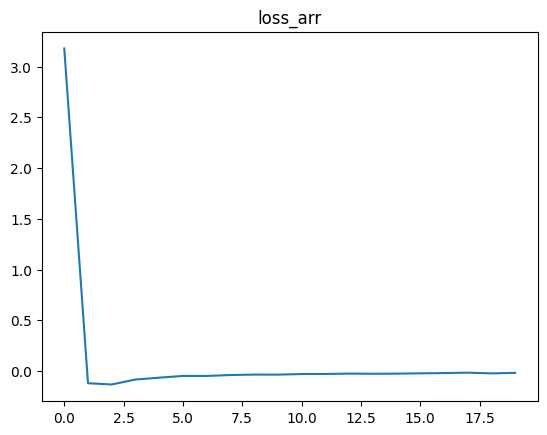

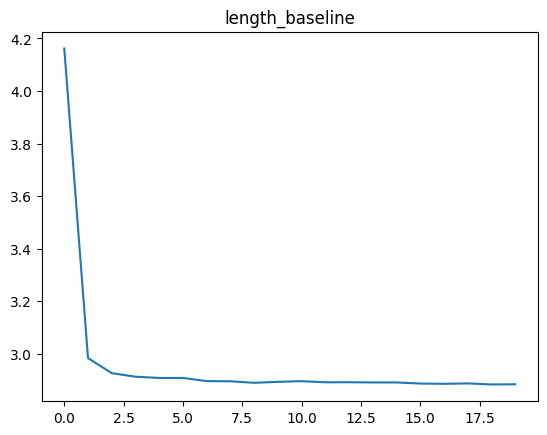

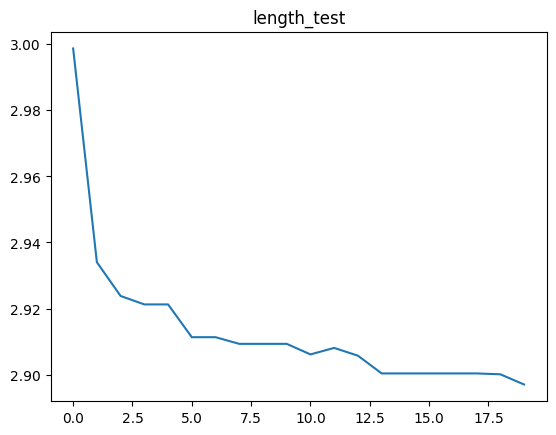

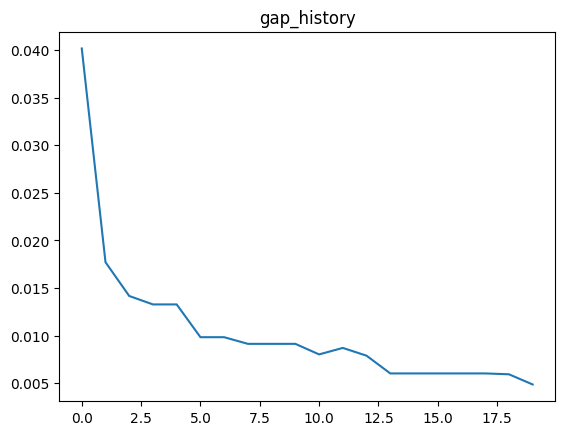

In [36]:
plt.plot(loss_arr)
plt.title('loss_arr')
plt.show()

plt.plot(length_baseline)
plt.title('length_baseline')
plt.show()

plt.plot(length_test)
plt.title('length_test')
plt.show()

plt.plot(gap_history)
plt.title('gap_history')
plt.show()

## Final check on test data

In [37]:
# generate topological features
# new_f = ...
data = x_test_tsp # np.concat(x_test_tsp, new_f)

with torch.no_grad():
    data = torch.tensor(np.array(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x_test_tsp)), dtype=torch.float32)
    tour_baseline, _ = model_baseline(data.to(device), deterministic=True)
    print(compute_tour_length(x_test_tsp, tour_baseline.to('cpu')).mean(), x_test_len)

tensor(2.8970) tensor(2.8830)


# Visualisation
Graphs should be fixed

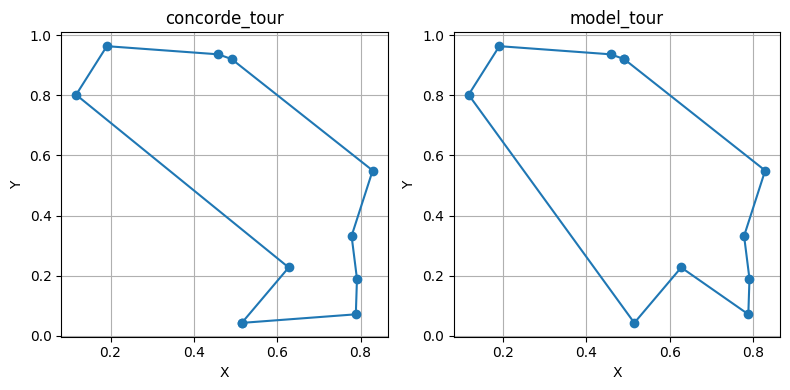

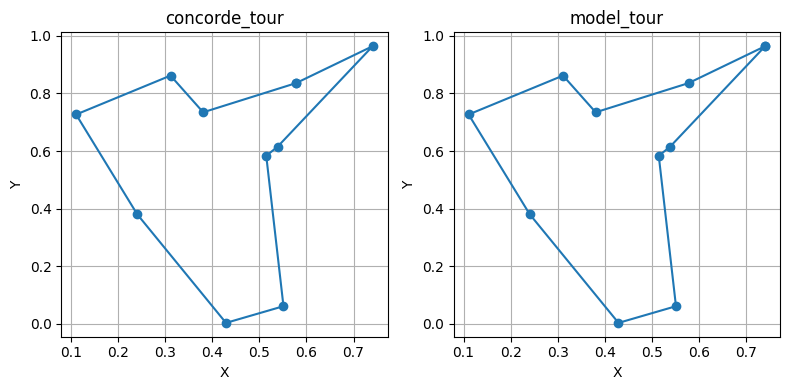

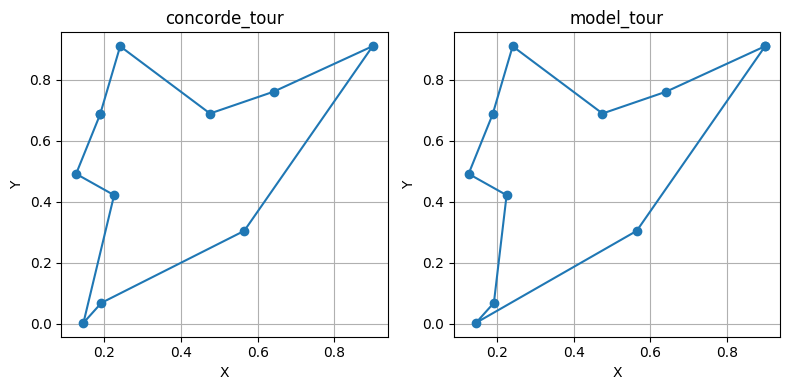

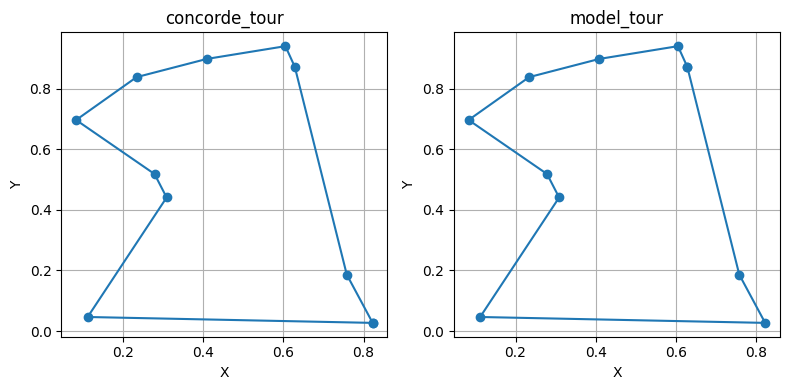

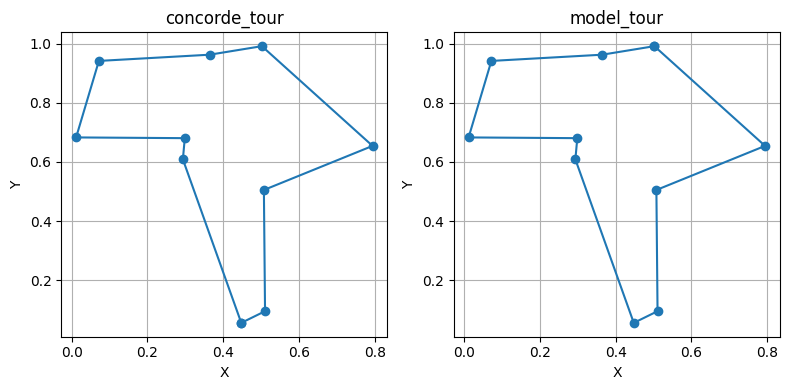

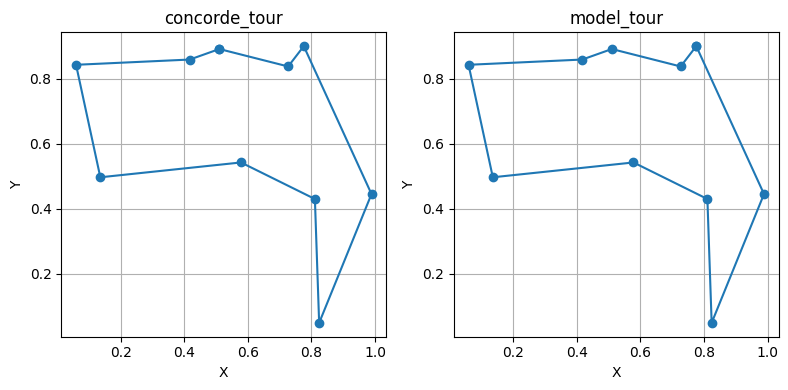

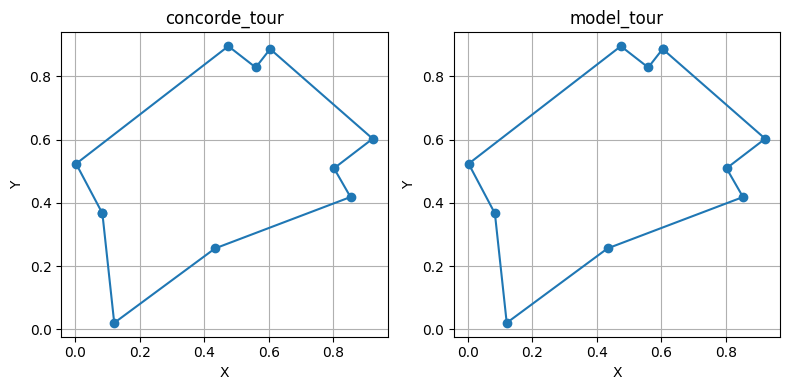

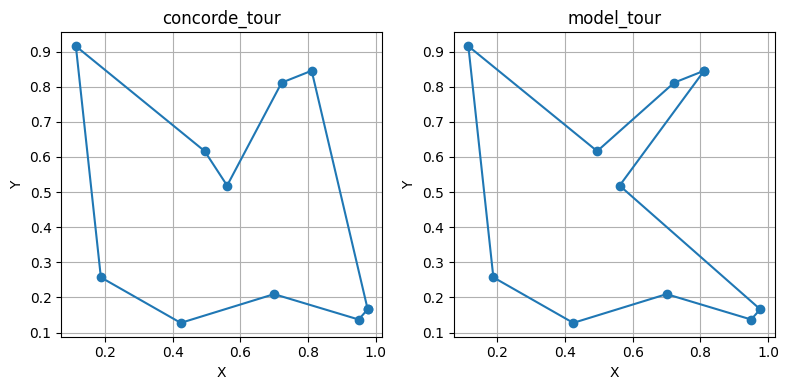

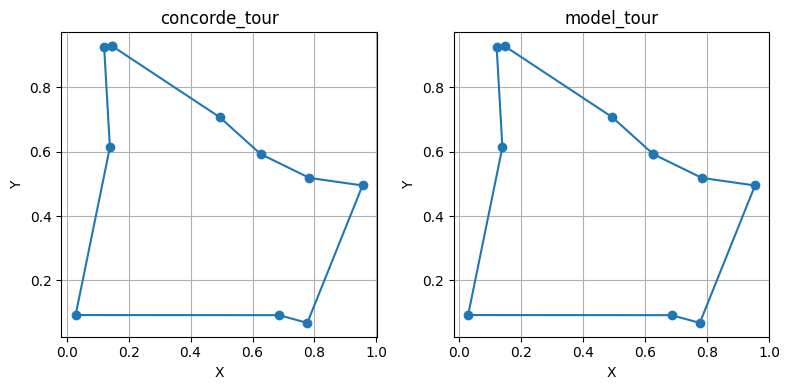

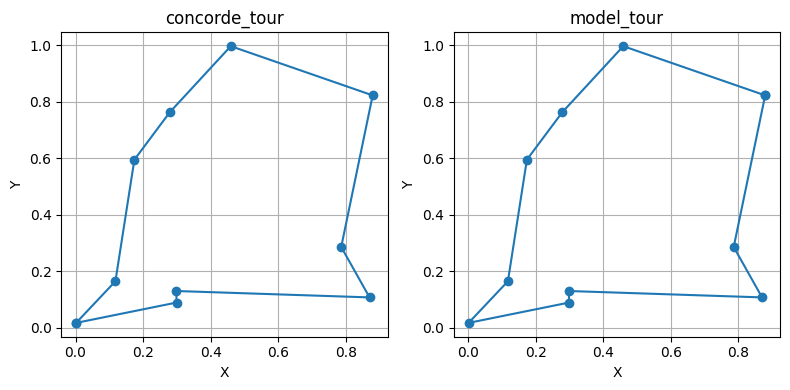

In [41]:
import matplotlib.pyplot as plt


for idx in range(10):
    points = np.array(x_test_tsp[idx].to('cpu'))

    model_tour = np.array(tour_baseline[idx].to('cpu'))
    concorde_tour = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False).tour

    sequence_points_concorde = points[concorde_tour]
    sequence_points_model = points[model_tour]

    # Connect last point with the first one
    sequence_points_concorde = np.vstack([sequence_points_concorde, sequence_points_concorde[0]])
    sequence_points_model = np.vstack([sequence_points_model, sequence_points_model[0]])


    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot concorde_tour
    axs[0].plot(sequence_points_concorde[:, 0], sequence_points_concorde[:, 1], marker='o', linestyle='-')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title('concorde_tour')
    axs[0].grid(True)

    # Plot model_tour
    axs[1].plot(sequence_points_model[:, 0], sequence_points_model[:, 1], marker='o', linestyle='-')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title('model_tour')
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'/content/pic_{idx}.png')

    # Show the plot
    plt.show()